In [5]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# disable warnings, use w caution
import warnings
warnings.filterwarnings('ignore')

# project specific libs
import os
import matplotlib.pyplot as plt
import pathlib

In [6]:
# set project path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/twinsra/'

In [7]:
# grab mapping file, partition samples and controls
df_map = pd.read_csv(path + 'inputs/Qiime2_0_KB/qiime_mapping_file_noctrl_no182183.tsv', sep='\t', index_col=0)

# get first row for any future operations
first_row = df_map.reset_index().iloc[0,]
first_row_df = pd.DataFrame(first_row).T
df_map = df_map.iloc[1:,]

# remove separate and together columns
df_map = df_map.drop(['Separate','Together'], axis=1)

# subset on useful columns
# TwinPair and Diagnosis are useful columns
df_map = df_map.loc[:,['TwinPair','Diagnosis']]

df_map.head()

,TwinPair,Diagnosis
#SampleID,,
500A.Fecal,T2,RA
501A.Fecal,T2,Unaffected
502A.Fecal,T3,RA
503A.Fecal,T3,Unaffected
504A.Fecal,T4,RA


0.034804507289198185 0.9730883744794505


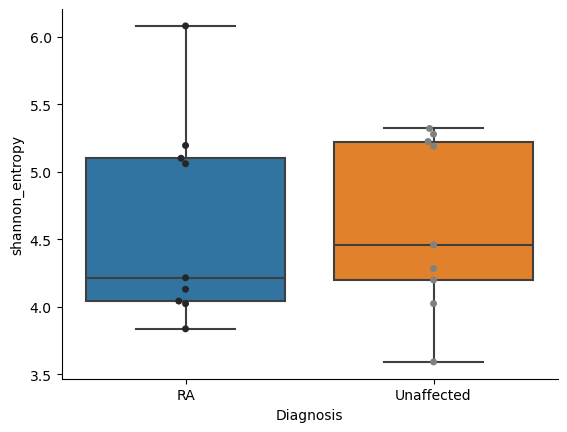

In [13]:
# paired shannon diversity difference from 0 
# this is from shannon_significance.qzv -> download as tsv
df_alpha = pd.read_csv(path + 'outputs/jobs08/alpha_shannon.tsv', sep='\t', index_col=0)

# drop unnecessary rows and cols
df_alpha = df_alpha.drop('#q2:types')
df_alpha = df_alpha.drop('Separate', axis=1)

# get paired per twin pair
pair_to_diff = {}
for p in list(df_alpha.TwinPair.values):
    df = df_alpha[df_alpha['TwinPair'] == p]
    alpha_UA = float(df[df['Diagnosis'] == 'Unaffected']['shannon_entropy'].values)
    alpha_RA = float(df[df['Diagnosis'] == 'RA']['shannon_entropy'].values)
    pair_to_diff[p] = alpha_RA - alpha_UA

df_paired_alpha = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=['Shannon_Diff'])

# one-sided t-test, n.s.; RA-UA values 
t, p = scipy.stats.ttest_1samp(df_paired_alpha['Shannon_Diff'],popmean=0)
print(t, p)

# boxplot of differences
#sns.boxplot(data=df_paired_alpha)
#sns.swarmplot(data=df_paired_alpha, palette='dark:grey')
#sns.despine()

# separate
df_alpha['shannon_entropy'] = df_alpha['shannon_entropy'].map(lambda x: float(x))
ax = sns.boxplot(data=df_alpha, x='Diagnosis', y='shannon_entropy')
sns.swarmplot(data=df_alpha, x='Diagnosis', y='shannon_entropy', palette='dark:grey')
sns.despine()

2.611074579651406 0.07986773212365678


<Axes: xlabel='category', ylabel='distance'>

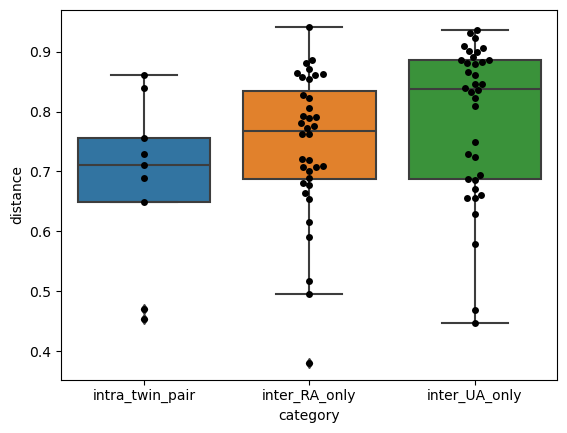

In [14]:
# paired beta div: unweighted distances to compare inter-twin vs inter-disease distances
# paired shannon diversity difference from 0 
df_beta = pd.read_csv(path + 'outputs/jobs08/Q2_outputs/bray_curtis_distance_matrix.tsv',
                      sep='\t', index_col=0)

# grab twin to pair dict
pair_to_ids = {}
for p in list(df_alpha.TwinPair.values):
    df = df_alpha[df_alpha['TwinPair'] == p]
    id_UA = str(df[df['Diagnosis'] == 'Unaffected'].index.values[0])
    id_RA = str(df[df['Diagnosis'] == 'RA'].index.values[0])
    pair_to_ids[p] = (id_UA, id_RA)

# get distances for each twin pair per beta div matrix    
pair_to_dist = {}
for p in list(df_alpha.TwinPair.values):
    id_UA, id_RA = pair_to_ids[p]
    pair_to_dist[p] = df_beta.loc[id_UA, id_RA]

df_paired_beta = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['Bray_Curtis'])

# grab inter RA distances
# this is from bray_curtis_significance_Diagnosis.qzv -> download as tsv
df_raw = pd.read_csv(path + 'outputs/jobs08/bray_curtis_raw_data.tsv', 
                     sep='\t', index_col=0)
df_RA = df_raw[df_raw['Group1'] == 'RA']
df_RA = df_RA[df_RA['Group2'] == 'RA']
df_UA = df_raw[df_raw['Group1'] == 'Unaffected']
df_UA = df_UA[df_UA['Group2'] == 'Unaffected']

# compare distances
inter_twin = df_paired_beta['Bray_Curtis'].values
inter_RA = df_RA['Distance'].values
inter_UA = df_UA['Distance'].values

u, p = scipy.stats.mannwhitneyu(inter_twin, inter_RA)
#print(u, p)

t, p = scipy.stats.ttest_ind(inter_twin, inter_RA)
#print(t, p)

t, p = scipy.stats.ttest_ind(inter_UA, inter_RA)
# print(t, p)

f, p = scipy.stats.f_oneway(inter_UA, inter_RA, inter_twin)
print(f, p)

category = ['intra_twin_pair']*len(inter_twin) + ['inter_RA_only']*len(inter_RA) + ['inter_UA_only']*len(inter_UA)
distances = list(inter_twin) + list(inter_RA) + list(inter_UA)
df_dist = pd.DataFrame(data=np.array([category,distances]).T, columns=['category','distance'])
df_dist['distance'] = df_dist['distance'].astype(float)

sns.boxplot(data=df_dist, x='category', y='distance')
sns.swarmplot(data=df_dist, x='category', y='distance', color='black')

0.0006623780609172667 0.9993378441860065


<Axes: xlabel='category', ylabel='distance'>

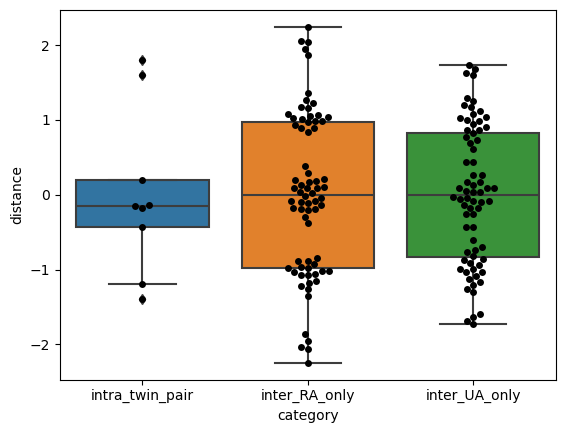

In [15]:
# paired alpha div: unweighted distances to compare inter-twin vs inter-disease distances
# paired shannon diversity difference from 0 
# grab twin to pair dict
# get distances for each twin pair per beta div matrix    
pair_to_dist = {}
for p in list(df_alpha.TwinPair.values):
    id_UA, id_RA = pair_to_ids[p]
    pair_to_dist[p] = df_alpha.loc[id_RA,'shannon_entropy'] - df_alpha.loc[id_UA,'shannon_entropy']
    
df_alpha_inter = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['shannon_entropy'])

# grab inter RA distances
df_RA = df_alpha[df_alpha['Diagnosis'] == 'RA']
RA_divs = list(df_RA['shannon_entropy'].values)
RA_diffs = [x - y for i,x in enumerate(RA_divs) for j,y in enumerate(RA_divs) if i != j]

# grab inter UA distances
df_UA = df_alpha[df_alpha['Diagnosis'] == 'Unaffected']
UA_divs = list(df_UA['shannon_entropy'].values)
UA_diffs = [x - y for i,x in enumerate(UA_divs) for j,y in enumerate(UA_divs) if i != j]

# compare distances
inter_twin = df_alpha_inter['shannon_entropy'].values
inter_RA = list(RA_diffs)
inter_UA = list(UA_diffs)

u, p = scipy.stats.mannwhitneyu(inter_twin, inter_RA)
# print(u, p)

t, p = scipy.stats.ttest_ind(inter_twin, inter_RA)
# print(t, p)

f, p = scipy.stats.f_oneway(inter_UA, inter_RA, inter_twin)
print(f, p)

category = ['intra_twin_pair']*len(inter_twin) + ['inter_RA_only']*len(inter_RA) + ['inter_UA_only']*len(inter_UA)
distances = list(inter_twin) + list(inter_RA) + list(inter_UA)
df_dist = pd.DataFrame(data=np.array([category,distances]).T, columns=['category','distance'])
df_dist['distance'] = df_dist['distance'].astype(float)

sns.boxplot(data=df_dist, x='category', y='distance')
sns.swarmplot(data=df_dist, x='category', y='distance', color='black')

15.0 0.2857142857142857
1.254270378592181 0.2500028414198213
0.25936143880072465 0.1482337330453945


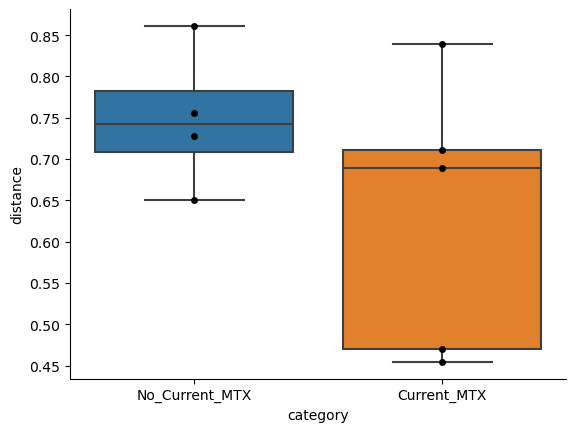

In [16]:
# investigate whether MTX treated twins converge to unaffected twins

# manually input metadata from Patient_data_KB.xls
samp_to_MTX = {
    '500A.Fecal': 1,
    '502A.Fecal': 1,
    '504A.Fecal': 1,
    '506A.Fecal': 0, # other DMARDs
    '508A.Fecal': 0, # unclear? HCQ
    '510A.Fecal': 1,
    '512A.Fecal': 1,
    '514A.Fecal': 0, # previosuly, not currently
    '516A.Fecal': 0, # in 2012, not currently,
}
# present MTX vs present biologic?
# to treatment
samp_to_tmt = {
    '500A.Fecal': 1, # MTX
    '502A.Fecal': 1, # MTX
    '504A.Fecal': 1, # MTX
    '506A.Fecal': 1, # other DMARDs
    '508A.Fecal': 1, # on HCQ
    '510A.Fecal': 1,
    '512A.Fecal': 1,
    '514A.Fecal': 0, # previously, not currently
    '516A.Fecal': 0, # in 2012, not currently,
}

# get copy
df_meta = df_map.copy()

# replace with column dict per above
df_meta['MTX'] = df_meta.index.map(samp_to_MTX)

# replace nan with 0 i.e. untreated
df_meta['MTX'] = df_meta['MTX'].fillna(0) 

# create TwinPair to MTX mapping
df = df_meta[df_meta['Diagnosis'] == 'RA'].set_index('TwinPair')
TP_to_MTX = df['MTX'].to_dict()

# Things to ask
# 1. Do the twin pair distances decrease in treated vs untreated twins?
df_paired_beta['MTX'] = df_paired_beta.index.map(TP_to_MTX)

# compare distances
inter_untreated = df_paired_beta[df_paired_beta['MTX'] == 0]['Bray_Curtis']
inter_treated = df_paired_beta[df_paired_beta['MTX'] == 1]['Bray_Curtis']

u, p = scipy.stats.mannwhitneyu(inter_untreated, inter_treated)
print(u, p)

t, p = scipy.stats.ttest_ind(inter_untreated, inter_treated)
print(t, p)

# sns.boxplot([inter_untreated, inter_treated])

category = ['No_Current_MTX']*len(inter_untreated) + ['Current_MTX']*len(inter_treated)
distances = list(inter_untreated) + list(inter_treated)
df_dist = pd.DataFrame(data=np.array([category,distances]).T, columns=['category','distance'])
df_dist['distance'] = df_dist['distance'].astype(float)

# f test of variance

F = np.var(inter_untreated) / np.var(inter_treated)
df1 = len(inter_untreated) - 1
df2 = len(inter_treated) - 1

p_value = scipy.stats.f.cdf(F, df1, df2)

print(F,p_value)

sns.boxplot(data=df_dist, x='category', y='distance')
sns.swarmplot(data=df_dist, x='category', y='distance', color='black')
sns.despine()

12.0 0.7301587301587302
0.15581860614470108 0.8805743202581782


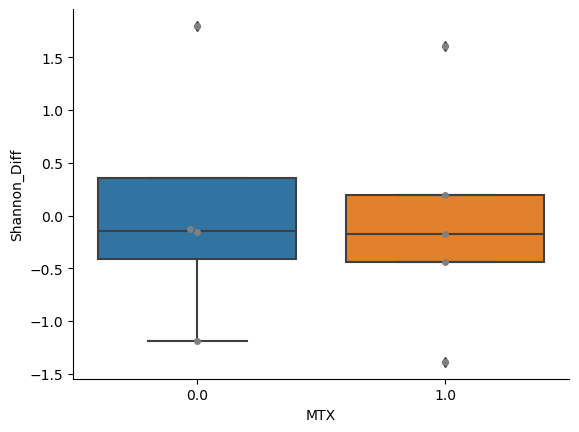

In [17]:
# compare distances
df_paired_div = pd.concat([df_paired_alpha, df_paired_beta], axis=1)

inter_untreated = df_paired_div[df_paired_div['MTX'] == 0]['Shannon_Diff']
inter_treated = df_paired_div[df_paired_div['MTX'] == 1]['Shannon_Diff']

u, p = scipy.stats.mannwhitneyu(inter_untreated, inter_treated)
print(u, p)

t, p = scipy.stats.ttest_ind(inter_untreated, inter_treated)
print(t, p)

#sns.boxplot([inter_untreated, inter_treated])
ax = sns.boxplot(data=df_paired_div, x='MTX', y='Shannon_Diff')
sns.swarmplot(data=df_paired_div, x='MTX', y='Shannon_Diff', color='grey')
sns.despine()

In [18]:
# add in metadata TJC and SJC
samp_to_TJC = {
    '501A.Fecal': 0,
    '503A.Fecal': 2,
    '505A.Fecal': 8,
    '507A.Fecal': 0,
    '509A.Fecal': 0,
    '511A.Fecal': 0,
    '513A.Fecal': 0,
    '515A.Fecal': 0,
    '500A.Fecal': 1, 
    '502A.Fecal': 7, 
    '504A.Fecal': 25, 
    '506A.Fecal': 21, 
    '508A.Fecal': 13,
    '510A.Fecal': 0,
    '512A.Fecal': 4,
    '514A.Fecal': 12, 
    '516A.Fecal': 1,
    '517A.Fecal': 0
}

samp_to_SJC = {
    '501A.Fecal': 0,
    '503A.Fecal': 0,
    '505A.Fecal': 2,
    '507A.Fecal': 0,
    '509A.Fecal': 0,
    '511A.Fecal': 0,
    '513A.Fecal': 0,
    '515A.Fecal': 0,
    '500A.Fecal': 1, 
    '502A.Fecal': 7, 
    '504A.Fecal': 27, 
    '506A.Fecal': 3, 
    '508A.Fecal': 6,
    '510A.Fecal': 0,
    '512A.Fecal': 1,
    '514A.Fecal': 5, 
    '516A.Fecal': 1,
    '517A.Fecal': 0
}

# why is 510 so well controlled...? even w/o steroids
# Actinomycetales?

# correlate SJC/TJC with distance
df_meta = df_map.copy()

# replace with column dict per above
df_meta['TJC'] = df_meta.index.map(samp_to_TJC)
df_meta['SJC'] = df_meta.index.map(samp_to_SJC)

# create TwinPair to var mapping
df = df_meta[df_meta['Diagnosis'] == 'RA'].set_index('TwinPair')
TP_to_TJC = df['TJC'].to_dict()
TP_to_SJC = df['SJC'].to_dict()

# create column in paired beta
df_paired_beta['SJC'] = df_paired_beta.index.map(TP_to_SJC)
df_paired_beta['TJC'] = df_paired_beta.index.map(TP_to_TJC)

df_paired_beta.head()

,Bray_Curtis,MTX,SJC,TJC
T2,0.710492,1.0,1,1
T3,0.470364,1.0,7,7
T4,0.688669,1.0,27,25
T5,0.728398,0.0,3,21
T6,0.755686,0.0,6,13


-0.10643268591639722 0.7852134861255494
-0.06404202196400337 0.869979748266139
-0.389886514581966 0.299588758586314
-0.2845213189769458 0.4580688437057311
0.6445987549868586 0.0609042946350627
0.6159490868449303 0.07737156936287011
0.6443571047419068 0.06103295769909979
0.4068381021724862 0.2771698777706746


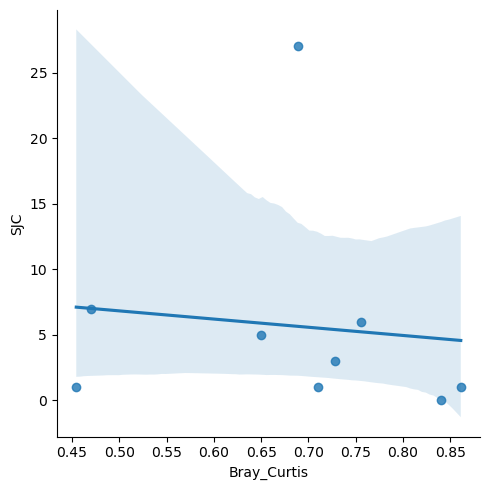

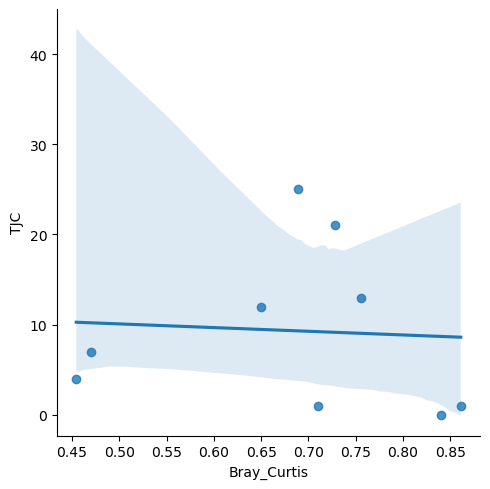

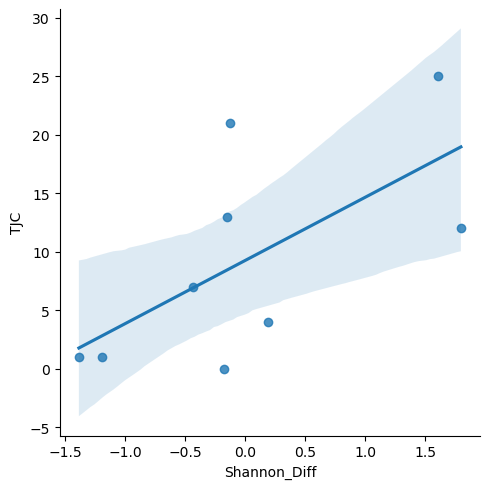

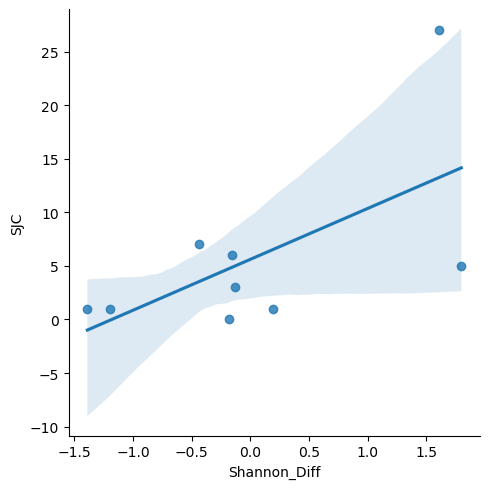

In [19]:
# conduct correlation
r, p = scipy.stats.pearsonr(x=df_paired_beta['Bray_Curtis'],y=df_paired_beta['SJC'])
sns.lmplot(data=df_paired_beta, x='Bray_Curtis', y='SJC')
print(r, p)

r, p = scipy.stats.pearsonr(x=df_paired_beta['Bray_Curtis'],y=df_paired_beta['TJC'])
sns.lmplot(data=df_paired_beta, x='Bray_Curtis', y='TJC')
print(r, p)

r, p = scipy.stats.spearmanr(a=df_paired_beta['Bray_Curtis'],b=df_paired_beta['SJC'])
print(r, p)

r, p = scipy.stats.spearmanr(a=df_paired_beta['Bray_Curtis'],b=df_paired_beta['TJC'])
print(r, p)

# alpha version of plot
df_paired_div = pd.concat([df_paired_alpha, df_paired_beta], axis=1)

r, p = scipy.stats.pearsonr(x=df_paired_div['Shannon_Diff'],y=df_paired_div['TJC'])
sns.lmplot(data=df_paired_div, x='Shannon_Diff', y='TJC')
print(r, p)

r, p = scipy.stats.pearsonr(x=df_paired_div['Shannon_Diff'],y=df_paired_div['SJC'])
sns.lmplot(data=df_paired_div, x='Shannon_Diff', y='SJC')
print(r, p)

r, p = scipy.stats.spearmanr(a=df_paired_div['Shannon_Diff'],b=df_paired_div['TJC'])
print(r, p)

r, p = scipy.stats.spearmanr(a=df_paired_div['Shannon_Diff'],b=df_paired_div['SJC'])
print(r, p)

In [20]:
# read in metaphlan taxa table
# both appear to be abs
#df_otu = pd.read_csv(path + 'outputs/ensemble_output/metaphlan_taxa_table_abs.tsv', sep='\t')
df_otu = pd.read_csv(path + 'outputs/ensemble_output/metaphlan_taxa_table.tsv', sep='\t', index_col=0)

# create taxonomy file
df_taxa = df_otu.reset_index()

# copy species column
df_taxa.iloc[:,1] = df_taxa['species'].values

# rename columns
df_taxa = df_taxa.rename({'species': 'Feature ID','500A': 'Taxon', '501A': 'Confidence'},axis='columns')

# set confidence level
df_taxa['Confidence'] = 0.99

# remove remaining columns
df_taxa = df_taxa.iloc[:,:3]

# set index
df_taxa = df_taxa.set_index('Feature ID')

# format taxa column
#df_taxa['Taxon'] = df_taxa['Taxon'].map(lambda x: x.replace(' ','_'))
#df_taxa['Taxon'] = df_taxa['Taxon'].map(lambda x: x.replace('|','; '))
df_taxa['Taxon'] = df_taxa['Taxon'].map(lambda x: 'g__' + x)
df_taxa['Taxon'] = df_taxa['Taxon'].map(lambda x: x.replace(' ', ';s__'))

# export as tsv
df_taxa.to_csv(path + 'outputs/jobs08/df_taxonomy.tsv', sep='\t')
# df_taxa.head()

# transpose and normalize
# load species table :) 
# df_otu = pd.read_csv(path + 'outputs/ensemble_humann3/twinsra_combined_taxa_table.tsv', sep='\t', index_col=0).T
# df_otu = pd.read_csv(path + 'outputs/ensemble_output/metaphlan_taxa_table.tsv', sep='\t', index_col=0).T
df_otu = df_otu.T
df_otu = df_otu.div(df_otu.sum(axis=1),axis=0)

df_otu.head()

species,Acidaminococcus intestini,Acinetobacter SGB14792,Actinomyces SGB17154,Actinomyces SGB17157,Actinomyces bouchesdurhonensis,Actinomyces sp ICM58,Adlercreutzia caecimuris,Adlercreutzia equolifaciens,Agathobaculum butyriciproducens,Akkermansia muciniphila,...,Veillonella atypica,Veillonella dispar,Veillonella parvula,Veillonella rogosae,Veillonellaceae bacterium,Vescimonas coprocola,Victivallis lenta,Victivallis vadensis,Waltera intestinalis,Weissella confusa
500A,0.027009,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000094,0.000000,...,0.000338,0.000199,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000294,0.0
501A,0.000000,0.000581,0.0,0.0,0.0,0.0,0.0,0.000000,0.000380,0.010196,...,0.000000,0.001672,0.000253,0.0,0.0,0.007709,0.0,0.0,0.007364,0.0
502A,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000903,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.001816,0.0,0.0,0.000000,0.0
503A,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000250,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.004581,0.0,0.0,0.000000,0.0
504A,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.001044,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [21]:
# Pathway data from humann3
# df_pathway 8579 cols
df_path = pd.read_csv(path + 'outputs/ensemble_humann3/humann3_joined_pathabundance_no_misses_relabund.tsv', sep='\t', index_col=0)
df_path = df_path.T
df_path.columns = df_path.columns.map(lambda x: x.replace('\'', 'prime'))
df_path.index = df_path.index.map(lambda x: x.split('_')[0])
df_path.head()

# Pathway,1CMET2-PWY: folate transformations III (E. coli),1CMET2-PWY: folate transformations III (E. coli)|g__Akkermansia.s__Akkermansia_muciniphila,1CMET2-PWY: folate transformations III (E. coli)|g__Alistipes.s__Alistipes_finegoldii,1CMET2-PWY: folate transformations III (E. coli)|g__Alistipes.s__Alistipes_putredinis,1CMET2-PWY: folate transformations III (E. coli)|g__Alistipes.s__Alistipes_sp_CAG_268,1CMET2-PWY: folate transformations III (E. coli)|g__Anaerostipes.s__Anaerostipes_hadrus,1CMET2-PWY: folate transformations III (E. coli)|g__Bacteroides.s__Bacteroides_caccae,1CMET2-PWY: folate transformations III (E. coli)|g__Bacteroides.s__Bacteroides_cellulosilyticus,1CMET2-PWY: folate transformations III (E. coli)|g__Bacteroides.s__Bacteroides_coprophilus,1CMET2-PWY: folate transformations III (E. coli)|g__Bacteroides.s__Bacteroides_dorei,...,VALSYN-PWY: L-valine biosynthesis|g__Ruminococcus.s__Ruminococcus_lactaris,VALSYN-PWY: L-valine biosynthesis|g__Ruthenibacterium.s__Ruthenibacterium_lactatiformans,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_parasanguinis,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_pneumoniae,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_salivarius,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_thermophilus,VALSYN-PWY: L-valine biosynthesis|g__Subdoligranulum.s__Subdoligranulum_sp_APC924_74,VALSYN-PWY: L-valine biosynthesis|g__Turicimonas.s__Turicimonas_muris,VALSYN-PWY: L-valine biosynthesis|g__Veillonella.s__Veillonella_dispar,VALSYN-PWY: L-valine biosynthesis|unclassified
500A,0.007639,0.00000,0.000000,0.000098,0.000000,0.000000,0.000015,0.0,0.000629,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000834
501A,0.008355,0.00011,0.000224,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000165,0.000000,0.000063,0.000078,0.000094,0.0,0.000101,0.000022,0.000045,0.001548
502A,0.010672,0.00000,0.000000,0.000382,0.000000,0.000056,0.000193,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000348,0.000000,0.000000,0.000871
503A,0.006938,0.00000,0.000000,0.000107,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000124,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000648
504A,0.009813,0.00000,0.000049,0.000503,0.000271,0.000000,0.000162,0.0,0.000000,0.0,...,0.000130,0.000129,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.002818


In [22]:
# df_meta: TwinPair, Diagnosis, TJC and SJC
df_meta_edit = df_meta.copy()
df_meta_edit.index = df_meta_edit.index.map(lambda x: x.split('.')[0])
df_meta_edit.head()

,TwinPair,Diagnosis,TJC,SJC
#SampleID,,,,
500A,T2,RA,1,1
501A,T2,Unaffected,0,0
502A,T3,RA,7,7
503A,T3,Unaffected,2,0
504A,T4,RA,25,27


In [23]:
# OLINK cytokine data, 92 columns
# drop OG rows 2-10 (1 indexed) and 20, the avg of 501 and 503 are used b/c they have repeat measures
df_olink = pd.read_csv(path + 'inputs/RA_twins/Normalized Olink TWINRA_RBB/Norm_Olink_TWINRA_KB.csv', index_col='Sample ID')
df_olink = df_olink.drop(['mtx Responder?','Twin pair','Timepoint','Group','Project','Dx', 'barcode'], axis=1)
df_olink = df_olink.dropna()
df_olink = df_olink.iloc[8:,:]

# for cleaning purposes and consistency:
# n this step, I removed columns (biomarkers) with 6 or more negative values. 
# There were 92 biomakers before the data cleaning, and I kept 86 of them. 
# get sum of number of negative values per column, hence axis = 0 which is default
df_olink = df_olink.loc[:, ((df_olink < 0).sum(axis=0) <= 5)]

# Also, I replaced all negative values in those 86 biomarkers with 0.
df_olink[df_olink < 0] = df_olink

# make index match other data
df_olink.index = df_olink.index.map(lambda x: x.split('.')[1] + 'A')
df_olink.head()

,IL8,VEGFA,CD8A,MCP.3,GDNF,CDCP1,CD244,IL7,OPG,LAP.TGF.beta.1,...,CX3CL1,TNFRSF9,NT.3,TWEAK,CCL20,ST1A1,STAMBP,ADA,TNFB,CSF.1
Sample ID,,,,,,,,,,,,,,,,,,,,,
501A,4.460090,11.747740,10.112573,0.692187,1.39987,3.256127,5.67191,0.716623,9.629157,6.129923,...,4.15028,6.636600,1.995827,9.269563,5.610247,1.866237,5.395570,6.546317,3.851637,9.882993
503A,5.640333,11.811737,9.727983,1.801717,1.41795,3.843057,5.06545,0.807270,9.408657,6.907237,...,4.50843,6.256277,2.298063,9.381473,7.969883,2.666090,6.828657,6.373057,4.304750,9.600263
505A,5.183700,11.414580,8.847250,0.740210,1.03830,3.077490,5.54233,0.497640,9.908030,6.267330,...,4.46019,6.141750,2.900720,9.146430,5.922580,2.619130,5.220380,6.155300,4.564380,9.629940
507A,4.888180,11.082720,9.029760,0.787420,0.93138,3.108910,5.12005,0.297860,9.616240,6.038080,...,3.95748,5.397950,0.909560,8.876210,6.204450,2.527400,4.836990,6.085700,3.006930,9.412340
509A,6.051210,12.279060,10.656030,1.387800,1.17672,4.046590,5.35261,2.330700,9.917410,7.123720,...,3.76442,6.645510,1.887630,9.608720,7.496650,4.781400,7.217610,6.351550,4.694640,9.953740


In [24]:
# metabolites, fatty acids; 11 collumns
df_fa = pd.read_csv(path + 'inputs/RA_twins/Metabolites/metabolites_KB.csv', index_col=0)
df_fa = df_fa.drop(['Subject','Sibling_pair'], axis=1)
df_fa = df_fa.drop(['182A','183A', 'Missing 507A'])
df_fa = df_fa.dropna()
df_fa.head()

,Acetate,Propionate,Butyrate,Isovalerate,Valerate,Hexanoate,Heptanoate,Octanoate,Nonanoic_acid,Decanoic_acid,Dodecanoic_acid
SampleID,,,,,,,,,,,
500A,63.203350,0.018168,0.123664,0.071874,0.258681,0.067507,0.000151,0.009360,0.003035,0.000109,18.961611
501A,144.772864,0.024557,0.257001,0.023236,0.018034,0.814973,0.012756,0.013322,0.003790,0.000128,23.364729
502A,24.348469,0.007449,0.103740,0.043493,0.186273,0.159585,0.000869,0.015359,0.002884,0.000077,6.222841
503A,72.685492,0.027111,0.183125,0.014804,0.036577,0.014324,0.000465,0.070759,0.004436,0.000069,11.350637
504A,27.178033,0.002476,0.022492,0.086892,0.271040,0.079170,0.010737,0.184629,0.012075,0.000072,26.324529


In [25]:
# plasma analytes
# 49 useful rows
#df_plasma = pd.read_csv(path + 'inputs/RA_twins/Analytes/Plasma_Analytes_COMPARISON_KB.csv', index_col=0)
df_plasma = pd.read_csv(path + 'inputs/RA_twins/Analytes/Plasma_Analytes_COMPARISON_KB.csv', index_col=0)
df_plasma = df_plasma.iloc[:48].T
df_plasma = df_plasma.drop(['Units','AVG1','TTEST','AVG2'])
df_plasma.index = df_plasma.index.map(lambda x: x.split('_')[0])
df_plasma = df_plasma.drop(['182A','183A'])

#df_fa = df_fa.drop(['Subject','Sibling_pair'], axis=1)
#df_fa = df_fa.drop(['182A','183A', 'Missing 507A'])
df_plasma.head()

Analyte,Hu IL-1b,Hu IL-1ra,Hu IL-2,Hu IL-4,Hu IL-5,Hu IL-6,Hu IL-7,Hu IL-8,Hu IL-9,Hu IL-10,...,Hu MCP-3,Hu M-CSF,Hu MIF,Hu MIG,Hu b-NGF,Hu SCF,Hu SCGF-b,Hu SDF-1a,Hu TNF-b,Hu TRAIL
500A,3.0,115.7,0.0,3.8,3.9,10.1,10.5,12.0,6.9,4.7,...,14.7,5.7,796.8,412.4,5.3,135.4,13591.9,690.5,0.0,87.4
502A,9.1,680.9,32.1,12.4,19.8,30.8,35.4,30.4,158.6,38.8,...,44.9,0.0,621.4,83.9,10.5,71.7,9937.8,868.5,0.0,95.4
504A,20.6,1338.8,100.1,42.3,36.1,80.4,69.3,126.4,86.7,92.7,...,4.0,0.0,586.0,277.8,4.9,50.6,7509.3,567.4,0.0,12.0
506A,5.4,280.1,0.0,9.0,9.9,19.2,17.2,25.1,12.0,17.9,...,20.6,0.0,691.8,221.2,7.5,73.8,7230.9,703.9,0.0,103.4
508A,5.1,307.7,5.5,7.9,8.7,15.1,15.3,20.6,39.8,19.6,...,29.6,5.4,827.0,355.0,10.3,73.8,8600.2,875.8,6.4,91.4


In [26]:
# acpas fecal
df_acpa_fecal = pd.read_csv(path + 'inputs/RA_twins/ACPA/CCP_Fecal_Analytes_COMPARISON_KB.csv', index_col=0)

# concatenate index
df_acpa_fecal.index = df_acpa_fecal.index + '_' + df_acpa_fecal['Secondary'] + '_Fecal'

# transpose
df_acpa_fecal = df_acpa_fecal.T

# drop useless rows
df_acpa_fecal = df_acpa_fecal.drop(['Secondary','Units', 'AVG1','TTESTP','AVG2','182A_F','183A_F'])

# convert to normal
df_acpa_fecal.index = df_acpa_fecal.index.map(lambda x: x.split('_')[0])
df_acpa_fecal.head()

,Biglycan 247-266 sm-1 cyclic _IgG_Fecal,Clusterin 231-250 sm-1 cyclic _IgG_Fecal,Mix B RBB _IgA_Fecal,ApoE 277-296 Cit2 sm2 cyclic _IgG_Fecal,H2B/a 62-81 cyclic _IgG_Fecal,ApoA1 Cit _IgG_Fecal,Mix C RBB _IgA_Fecal,FibrinogenB 36-52 cit _IgG_Fecal,FibrinogenB 246-267 cit _IgG_Fecal,Vimentin 58-77 cit3 cyclic small-1 _IgG_Fecal,...,Vimentin _IgG_Fecal,Fibrinogen _IgG_Fecal,Fibrinogen cit _IgG_Fecal,Filaggrin 48-65 arg2 v1 cyclic _IgG_Fecal,Fibronectin cit _IgA_Fecal,FibrinogenA 556-575 sm cyclic _IgG_Fecal,Histones2B cit _IgG_Fecal,Fibronectin cit 1029-1042 cit2 _IgG_Fecal,FibrinogenA 211-230 cit small cyclic _IgG_Fecal,Mix B RBB _IgG_Fecal
500A,18,15,47,47,16,18,48,23,21,17,...,31,136,109,17,131,18,17,17,32,43
502A,20,15,48,45,16,19,48,21,20,17,...,29,143,113,15,132,17,37,16,30,45
504A,18,16,50,46,15,19,45,23,20,15,...,26,130,109,16,135,17,18,15,33,44
506A,19,15,46,45,16,22,48,23,19,17,...,27,129,109,15,138,14,15,17,32,47
508A,33,22,78,50,18,21,62,23,19,15,...,28,130,108,20,141,22,20,17,33,49


In [27]:
# acpas plasma
df_acpa_plasma = pd.read_csv(path + 'inputs/RA_twins/ACPA/CCP_Plasma_Analytes_COMPARISON_KB.csv', index_col=0)

# convert first nan to ccp
df_acpa_plasma.iloc[0,0] = 'ccpnan'

# concatenate index
df_acpa_plasma.index = df_acpa_plasma.index + '_' + df_acpa_plasma['Secondary'] + '_Plasma'

# transpose
df_acpa_plasma = df_acpa_plasma.T

# drop useless rows
df_acpa_plasma = df_acpa_plasma.drop(['Secondary','Units', 'AVG1','TTESTP','AVG2','182A_P','183A_P'])

# convert to normal
df_acpa_plasma.index = df_acpa_plasma.index.map(lambda x: x.split('_')[0])
df_acpa_plasma.head()

,CCP 3.1_ccpnan_Plasma,FibrinogenA 41-60 cit3 cyclic _IgA_Plasma,FibrinogenA 27-43 cit _IgA_Plasma,Biglycan 247-266 cit sm-1 cyclic _IgA_Plasma,FibrinogenA 41-60 cyclic _IgA_Plasma,H2B/a 62-81 cyclic _IgA_Plasma,ApoE 277-296 Cit2 sm2 cyclic _IgG_Plasma,Enolase-1A 5-21 cit _IgA_Plasma,FibrinogenA 556-575 sm cyclic _IgA_Plasma,FibrinogenB 54-72 _IgA_Plasma,...,ApoA1 Cit _IgA_Plasma,H2B/a 62-81 cit cyclic _IgG_Plasma,Histones2B _IgG_Plasma,ApoA1 _IgA_Plasma,Mix C SVB _IgA_Plasma,Histones2A cit _IgG_Plasma,H2A/a 1-20 cit sm-2 cyclic _IgA_Plasma,Histones2A cit _IgA_Plasma,FibrinogenA 556-575 cit sm cyclic _IgA_Plasma,Vimentin 58-77 cit3 cyclic small-1 _IgA_Plasma
500A,0,21,44,32,33,38,64,67,36,43,...,19,35,46,20,45,34,47,34,29,51
502A,94384.5,46.0,36.0,53.0,65.0,74.0,75.0,437.0,79.0,74.0,...,35.0,233.0,47.0,26.0,89.0,722.0,166.0,154.0,66.0,228.0
504A,4406.13,22.0,25.0,26.0,27.0,32.0,64.0,137.0,29.0,37.0,...,21.0,34.0,45.0,19.0,49.0,55.0,29.0,437.0,26.0,25.0
506A,1010,26,26,36,43,42,113,64,43,53,...,24,79,88,29,77,31,34,125,32,30
508A,47444.8,51.0,33.0,36.0,41.0,48.0,83.0,347.0,52.0,58.0,...,23.0,1101.0,56.0,26.0,76.0,247.0,34.0,83.0,61.0,49.0


In [42]:
# combine them all!
df_final = pd.concat([df_meta_edit, df_otu, df_path, df_olink, df_fa, df_acpa_fecal, df_acpa_plasma, df_plasma], axis=1)
df_final = df_final.drop(['TwinPair'],axis=1)
df_final.columns = df_final.columns.map(lambda x: x.replace('\'','prime'))
df_final.to_csv(path + 'inputs/df_final.tsv', sep='\t',index_label='SampleID')

# combine them all except OTU and path
df_quant = pd.concat([df_meta_edit, df_olink, df_fa, df_acpa_fecal, df_acpa_plasma, df_plasma], axis=1)
df_quant = df_quant.drop(['TwinPair'],axis=1)
df_quant.columns = df_quant.columns.map(lambda x: x.replace('\'','prime'))
df_quant.to_csv(path + 'inputs/df_quant.tsv', sep='\t',index_label='SampleID')

# create new df for asv
df_asv = pd.concat([df_meta_edit, df_otu], axis=1) 
df_asv = df_asv.drop(['TwinPair','SJC','TJC'],axis=1)
df_asv.to_csv(path + 'inputs/df_asv.tsv', sep='\t',index_label='SampleID')

# testing/smaller datasets
queries = ['Blautia faecis', 'Bilophila wadsworthia', 'Alistipes shahii']
df_asv_test = df_asv.loc[:,['Diagnosis'] + queries]
# df_asv_test = df_asv.iloc[:,0:20]
df_asv_test.to_csv(path + 'inputs/df_asv_test.tsv', sep='\t',index_label='SampleID')

df_quant_test = df_quant.iloc[:,0:20]
df_quant_test.to_csv(path + 'inputs/df_quant_test.tsv', sep='\t',index_label='SampleID')
df_asv_test.head()

,Diagnosis,Blautia faecis,Bilophila wadsworthia,Alistipes shahii
500A,RA,0.000356,0.001744,0.001544
501A,Unaffected,0.003512,0.000000,0.000000
502A,RA,0.001538,0.001248,0.005724
503A,Unaffected,0.000986,0.000000,0.000000
504A,RA,0.001380,0.000000,0.011053


In [69]:
# subset for dgca subplots
df = pd.concat([df_meta_edit, df_olink], axis=1)
df = df.drop(['TwinPair', 'Diagnosis', 'TJC', 'SJC'],axis=1)
#df = df.drop(['TwinPair'],axis=1)
df.columns = df.columns.map(lambda x: x.replace('\'','prime'))
# df.to_csv(path + 'inputs/df_olink_meta.tsv', sep='\t',index_label='SampleID')
df.to_csv(path + 'inputs/df_olink.tsv', sep='\t',index_label='SampleID')

df = pd.concat([df_meta_edit, df_fa], axis=1)
df = df.drop(['TwinPair', 'Diagnosis', 'TJC', 'SJC'],axis=1)
#df = df.drop(['TwinPair'],axis=1)
df.columns = df.columns.map(lambda x: x.replace('\'','prime'))
df.to_csv(path + 'inputs/df_fa.tsv', sep='\t',index_label='SampleID')

df = pd.concat([df_meta_edit, df_acpa_fecal], axis=1)
df = df.drop(['TwinPair', 'Diagnosis', 'TJC', 'SJC'],axis=1)
#df = df.drop(['TwinPair'],axis=1)
df.columns = df.columns.map(lambda x: x.replace('\'','prime'))
df.to_csv(path + 'inputs/df_acpa_fecal.tsv', sep='\t',index_label='SampleID')

df = pd.concat([df_meta_edit, df_acpa_plasma], axis=1)
df = df.drop(['TwinPair', 'Diagnosis', 'TJC', 'SJC'],axis=1)
#df = df.drop(['TwinPair'],axis=1)
df.columns = df.columns.map(lambda x: x.replace('\'','prime'))
df.to_csv(path + 'inputs/df_acpa_plasma.tsv', sep='\t',index_label='SampleID')

df = pd.concat([df_meta_edit, df_plasma], axis=1)
df = df.drop(['TwinPair', 'Diagnosis', 'TJC', 'SJC'],axis=1)
#df = df.drop(['TwinPair'],axis=1)
df.columns = df.columns.map(lambda x: x.replace('\'','prime'))
df.to_csv(path + 'inputs/df_plasma.tsv', sep='\t',index_label='SampleID')
df.head()


,Diagnosis,TJC,SJC,Hu IL-1b,Hu IL-1ra,Hu IL-2,Hu IL-4,Hu IL-5,Hu IL-6,Hu IL-7,...,Hu MCP-3,Hu M-CSF,Hu MIF,Hu MIG,Hu b-NGF,Hu SCF,Hu SCGF-b,Hu SDF-1a,Hu TNF-b,Hu TRAIL
500A,RA,1,1,3.0,115.7,0.0,3.8,3.9,10.1,10.5,...,14.7,5.7,796.8,412.4,5.3,135.4,13591.9,690.5,0.0,87.4
501A,Unaffected,0,0,4.3,444.3,2.2,6.6,7.6,17.0,17.2,...,99.2,27.9,864.1,548.3,5.8,119.9,17925.1,648.8,0.0,58.4
502A,RA,7,7,9.1,680.9,32.1,12.4,19.8,30.8,35.4,...,44.9,0.0,621.4,83.9,10.5,71.7,9937.8,868.5,0.0,95.4
503A,Unaffected,2,0,9.1,603.4,21.6,16.7,17.0,33.7,31.2,...,35.4,4.8,689.5,192.4,10.7,83.2,7945.3,846.2,0.0,97.4
504A,RA,25,27,20.6,1338.8,100.1,42.3,36.1,80.4,69.3,...,4.0,0.0,586.0,277.8,4.9,50.6,7509.3,567.4,0.0,12.0


In [68]:
df = pd.concat([df_meta_edit, df_plasma], axis=1)
df = df.drop(['TwinPair', 'Diagnosis', 'TJC', 'SJC'],axis=1)
#df = df.drop(['TwinPair'],axis=1)
df.columns = df.columns.map(lambda x: x.replace('\'','prime'))
#df.to_csv(path + 'inputs/df_plasma.tsv', sep='\t',index_label='SampleID')
df.columns.values
# df.head()

array(['Hu IL-1b ', 'Hu IL-1ra ', 'Hu IL-2 ', 'Hu IL-4 ', 'Hu IL-5 ',
       'Hu IL-6 ', 'Hu IL-7 ', 'Hu IL-8 ', 'Hu IL-9 ', 'Hu IL-10 ',
       'Hu IL-12(p70) ', 'Hu IL-13 ', 'Hu IL-15 ', 'Hu IL-17 ',
       'Hu Eotaxin ', 'Hu FGF basic ', 'Hu G-CSF ', 'Hu GM-CSF ',
       'Hu IFN-g ', 'Hu IP-10 ', 'Hu MCP-1(MCAF) ', 'Hu MIP-1a ',
       'Hu MIP-1b ', 'Hu PDGF-bb ', 'Hu RANTES ', 'Hu TNF-a ', 'Hu VEGF ',
       'Hu IFN-a2 ', 'Hu IL-1a ', 'Hu IL-2Ra ', 'Hu IL-3 ',
       'Hu IL-12p40 ', 'Hu IL-16 ', 'Hu IL-18 ', 'Hu CTACK ', 'Hu GROa ',
       'Hu HGF ', 'Hu LIF ', 'Hu MCP-3 ', 'Hu M-CSF ', 'Hu MIF ',
       'Hu MIG ', 'Hu b-NGF ', 'Hu SCF ', 'Hu SCGF-b ', 'Hu SDF-1a ',
       'Hu TNF-b ', 'Hu TRAIL '], dtype=object)

In [43]:
# subset for CUTIE into sep groups
df_asv_RA_test = df_asv_test[df_asv_test['Diagnosis'] == 'RA']
df_asv_RA_test = df_asv_RA_test.drop('Diagnosis',axis=1)
df_asv_RA_test.to_csv(path + 'inputs/df_asv_RA_test.tsv', sep='\t',index_label='SampleID')
df_asv_UA_test = df_asv_test[df_asv_test['Diagnosis'] == 'Unaffected']
df_asv_UA_test = df_asv_UA_test.drop('Diagnosis',axis=1)
df_asv_UA_test.to_csv(path + 'inputs/df_asv_UA_test.tsv', sep='\t',index_label='SampleID')

df_quant_RA_test = df_quant_test[df_quant_test['Diagnosis'] == 'RA']
df_quant_RA_test = df_quant_RA_test.drop('Diagnosis',axis=1)
df_quant_RA_test.to_csv(path + 'inputs/df_quant_RA_test.tsv', sep='\t',index_label='SampleID')
df_quant_UA_test = df_quant_test[df_quant_test['Diagnosis'] == 'Unaffected']
df_quant_UA_test = df_quant_UA_test.drop('Diagnosis',axis=1)
df_quant_UA_test.to_csv(path + 'inputs/df_quant_UA_test.tsv', sep='\t',index_label='SampleID')
df_quant_UA_test.head()

,TJC,SJC,IL8,VEGFA,CD8A,MCP.3,GDNF,CDCP1,CD244,IL7,OPG,LAP.TGF.beta.1,uPA,IL6,IL.17C,MCP.1,IL.17A,CXCL11,AXIN1
501A,0,0,4.460090,11.747740,10.112573,0.692187,1.39987,3.256127,5.67191,0.716623,9.629157,6.129923,10.33028,1.619767,3.587467,11.520863,0.540667,7.261210,2.586070
503A,2,0,5.640333,11.811737,9.727983,1.801717,1.41795,3.843057,5.06545,0.807270,9.408657,6.907237,10.19101,2.955643,1.320887,11.372133,0.263913,7.799223,5.251517
505A,8,2,5.183700,11.414580,8.847250,0.740210,1.03830,3.077490,5.54233,0.497640,9.908030,6.267330,10.08290,1.776640,1.986970,11.144380,0.313540,7.530980,5.217950
507A,0,0,4.888180,11.082720,9.029760,0.787420,0.93138,3.108910,5.12005,0.297860,9.616240,6.038080,10.44970,2.899500,0.686070,10.943530,0.532660,6.508680,4.390880
509A,0,0,6.051210,12.279060,10.656030,1.387800,1.17672,4.046590,5.35261,2.330700,9.917410,7.123720,10.61110,2.754510,1.950290,11.858130,0.047320,8.697620,6.683230


In [44]:
# subset for CUTIE into sep groups
df_asv_RA = df_asv[df_asv['Diagnosis'] == 'RA']
df_asv_RA = df_asv_RA.drop('Diagnosis',axis=1)
df_asv_RA.to_csv(path + 'inputs/df_asv_RA.tsv', sep='\t',index_label='SampleID')
df_asv_UA = df_asv[df_asv['Diagnosis'] == 'Unaffected']
df_asv_UA = df_asv_UA.drop('Diagnosis',axis=1)
df_asv_UA.to_csv(path + 'inputs/df_asv_UA.tsv', sep='\t',index_label='SampleID')

df_quant_RA = df_quant[df_quant['Diagnosis'] == 'RA']
df_quant_RA = df_quant_RA.drop('Diagnosis',axis=1)
df_quant_RA.to_csv(path + 'inputs/df_quant_RA.tsv', sep='\t',index_label='SampleID')
df_quant_UA = df_quant[df_quant['Diagnosis'] == 'Unaffected']
df_quant_UA = df_quant_UA.drop('Diagnosis',axis=1)
df_quant_UA.to_csv(path + 'inputs/df_quant_UA.tsv', sep='\t',index_label='SampleID')
df_asv_UA.head()

,Acidaminococcus intestini,Acinetobacter SGB14792,Actinomyces SGB17154,Actinomyces SGB17157,Actinomyces bouchesdurhonensis,Actinomyces sp ICM58,Adlercreutzia caecimuris,Adlercreutzia equolifaciens,Agathobaculum butyriciproducens,Akkermansia muciniphila,...,Veillonella atypica,Veillonella dispar,Veillonella parvula,Veillonella rogosae,Veillonellaceae bacterium,Vescimonas coprocola,Victivallis lenta,Victivallis vadensis,Waltera intestinalis,Weissella confusa
501A,0.000000,0.000581,0.0,0.0,0.0,0.0,0.0,0.000000,0.000380,0.010196,...,0.0,0.001672,0.000253,0.0,0.0,0.007709,0.000000,0.000000,0.007364,0.0
503A,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000250,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.004581,0.000000,0.000000,0.000000,0.0
505A,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.011790,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
507A,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.009786,0.000000,0.000651,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
509A,0.001133,0.000000,0.0,0.0,0.0,0.0,0.0,0.000039,0.000074,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000117,0.000297,0.000009,0.007894,0.0


In [ ]:
# rename without Fecal suffix for ensemble fastq's
# grab mapping file, partition samples and controls
df_map = pd.read_csv(path + 'inputs/Qiime2_0_KB/qiime_mapping_file_noctrl_no182183.tsv', sep='\t', index_col=0)
df_map = df_map.reset_index()
new_sid = [x.replace('.Fecal','') for x in list(df_map['#SampleID'].values)]
df_map['#SampleID'] = new_sid
df_map = df_map.set_index('#SampleID')
df_map.to_csv(path + 'inputs/Qiime2_1_KB/qiime_mapping_file_noctrl_no182183_ensemble.tsv', sep='\t')
df_map.head()

In [ ]:
%%capture
# pathway analysis
# collect individual pathway dfs
#pathway_fps = pathlib.Path(path + 'outputs/ensemble_humann3/').glob('*A_genefamilies.tsv')
pathway_fps = pathlib.Path(path + 'outputs/ensemble_humann3/').glob('*A_pathabundance.tsv')

# collect and parse dfs
dfs = []
for fp in pathway_fps:
    df = pd.read_csv(path + 'outputs/ensemble_humann3/' + fp.name, sep='\t', index_col=0)
    df = df/df.sum()
    dfs.append(df)

# merge dataframes
df_pathway = pd.concat(dfs, axis=1).T

# replace nan with 0
df_pathway = df_pathway.replace(np.nan,0)

# test first x pathways
# df_pathway = df_pathway.iloc[:,:100]

# conduct KW test
RA_ids = ['512A_Abundance',#-RPKs', 
          '516A_Abundance',#-RPKs',
          '508A_Abundance',#-RPKs', 
          '514A_Abundance',#-RPKs',
          '502A_Abundance',#-RPKs',
          '500A_Abundance',#-RPKs',
          '510A_Abundance',#-RPKs',
          '504A_Abundance']#-RPKs',

UA_ids = ['513A_Abundance',#-RPKs', 
          '517A_Abundance',#-RPKs', 
          '509A_Abundance',#-RPKs', 
          '515A_Abundance',#-RPKs',
          '503A_Abundance',#-RPKs', 
          '501A_Abundance',#-RPKs',
          '511A_Abundance',#-RPKs',
          '505A_Abundance']#-RPKs']

pathways = list(df_pathway.columns.values)

# SR ONLY
names = []
tvals = []
pvals = []
test = []
direction = []

for x in pathways:
    plot = False
    RA_vals = df_pathway.loc[RA_ids,x].values
    UA_vals = df_pathway.loc[UA_ids,x].values
    try:
        #h,p = scipy.stats.kruskal(RA_vals, UA_vals)
        if np.median(RA_vals) > np.median(UA_vals):
            d = 'RA'
        else:
            d = 'UA'
        #names.append(x)
        #tvals.append(h)
        #pvals.append(p)
        #test.append('KW')
        #direction.append(d)
        #if p<0.05:
        #    plot = True
        diff = RA_vals - UA_vals
        if sum(np.isnan(diff)) < 2:
            w,p = scipy.stats.wilcoxon(RA_vals, UA_vals)
            names.append(x)
            tvals.append(w)
            pvals.append(p)
            test.append('SR')
            direction.append(d)
            if p < 0.05:
                plot = True
    except:
        plot = False
    if plot:
        #sns.stripplot([RA_vals, UA_vals])
        sns.boxplot([RA_vals, UA_vals])
        plt.title(x)
        plt.savefig(path + 'outputs/ensemble_humann3/sig_metacyc/' + x + '.pdf',  bbox_inches="tight")
        plt.close()

df_sigpath = pd.DataFrame.from_dict({
    'pathway': names,
    'test_stat': tvals,
    'pvalue': pvals,
    'test': test,
    'direction': direction
})
df_sigpath = df_sigpath.set_index('pathway')
df_sigpath['FDR_bh'] = scipy.stats.false_discovery_control(df_sigpath['pvalue'].values)
df_sigpath_FDR = df_sigpath[df_sigpath['FDR_bh'] < 0.05]
df_sigpath = df_sigpath[df_sigpath['pvalue'] < 0.05] 
df_sigpath.to_csv(path + 'outputs/ensemble_humann3/df_sigpath.tsv', sep='\t')
df_sigpath_FDR.to_csv(path + 'outputs/ensemble_humann3/df_sigpath_FDR.tsv', sep='\t')




In [ ]:
%%capture
# pathway analysis for KO
# collect individual pathway dfs
#pathway_fps = pathlib.Path(path + 'outputs/ensemble_humann3/').glob('*A_genefamilies.tsv')
# pathway_fps = pathlib.Path(path + 'outputs/ensemble_humann3/').glob('*A_pathabundance.tsv')
df_pathway = pd.read_csv(path + 'outputs/ensemble_humann3/humann3_joined_KO_no_misses_relabund_nobar_brite.tsv', sep='\t')

# set index and transpose
df_pathway = df_pathway.set_index('pathways')
df_pathway = df_pathway.T

# rename samples
df_pathway.index = df_pathway.index.map(lambda x: x.split('_')[0] + '_Abundance')

# test first x pathways
# df_pathway = df_pathway.iloc[:,:100]

# conduct KW test
RA_ids = ['512A_Abundance',#-RPKs', 
          '516A_Abundance',#-RPKs',
          '508A_Abundance',#-RPKs', 
          '514A_Abundance',#-RPKs',
          '502A_Abundance',#-RPKs',
          '500A_Abundance',#-RPKs',
          '510A_Abundance',#-RPKs',
          '504A_Abundance']#-RPKs',

UA_ids = ['513A_Abundance',#-RPKs', 
          '517A_Abundance',#-RPKs', 
          '509A_Abundance',#-RPKs', 
          '515A_Abundance',#-RPKs',
          '503A_Abundance',#-RPKs', 
          '501A_Abundance',#-RPKs',
          '511A_Abundance',#-RPKs',
          '505A_Abundance']#-RPKs']

pathways = list(df_pathway.columns.values)

names = []
tvals = []
pvals = []
test = []

for x in pathways:
    plot = False
    RA_vals = df_pathway.loc[RA_ids,x].values
    UA_vals = df_pathway.loc[UA_ids,x].values
    try:
        #h,p = scipy.stats.kruskal(RA_vals, UA_vals)
        #if p < 0.05:
        #    names.append(x)
        #    tvals.append(h)
        #    pvals.append(p)
        #    test.append('KW')
        #    plot = True
        diff = RA_vals - UA_vals
        if sum(np.isnan(diff)) < 2:
            w,p = scipy.stats.wilcoxon(RA_vals, UA_vals)
            names.append(x)
            tvals.append(w)
            pvals.append(p)
            test.append('SR')
            if p < 0.05:
                plot = True
    except:
        plot = False
    if plot:
        #sns.stripplot([RA_vals, UA_vals])
        sns.boxplot([RA_vals, UA_vals])
        plt.title(x)
        plt.savefig(path + 'outputs/ensemble_humann3/sig_ko/' + x + '.pdf',  bbox_inches="tight")
        plt.close()

df_sigpath = pd.DataFrame.from_dict({
    'pathway': names,
    'test_stat': tvals,
    'pvalue': pvals,
    'test': test
})
df_sigpath = df_sigpath.set_index('pathway')
df_sigpath['FDR_bh'] = scipy.stats.false_discovery_control(df_sigpath['pvalue'].values)
df_sigpath_FDR = df_sigpath[df_sigpath['FDR_bh'] < 0.05]
df_sigpath = df_sigpath[df_sigpath['pvalue'] < 0.05] 
df_sigpath.to_csv(path + 'outputs/ensemble_humann3/df_sigko.tsv', sep='\t')
df_sigpath_FDR.to_csv(path + 'outputs/ensemble_humann3/df_sigko_FDR.tsv', sep='\t')



In [ ]:
# split by samples
RA = list(df_final[df_final['Diagnosis'] == 'RA'].index.values)
UA = list(df_final[df_final['Diagnosis'] == 'Unaffected'].index.values)

df_q2R = df_asv.drop(['Diagnosis','TJC','SJC'],axis=1).T
df_q2R['UA_mean'] = df_q2R[UA].mean(axis=1)
df_q2R['RA_mean'] = df_q2R[RA].mean(axis=1)
df_q2R = df_q2R[['RA_mean','UA_mean']]
df_q2R.index.name = 'Species'
df_q2R.to_csv(path + 'inputs/df_q2R.tsv', sep='\t')
df_q2R.head()
# df_q2R


In [ ]:
# compute euclidian distance matrix for future pcoa
from scipy.spatial.distance import squareform, pdist

dist_olink = pd.DataFrame(squareform(pdist(df_olink.iloc[:, 1:])), columns=df_olink.index.unique(), index=df_olink.index.unique())
dist_olink.to_csv(path + 'inputs/df_olink_eucdist.tsv', sep='\t')
dist_olink.shape()


In [ ]:
# identify butyrate production
pathways = list(df_pathway.columns.values)
queries = ['butanoate','octanoate']

for q in queries:
    for x in pathways:
        pathway = x.lower()
        if q in pathway:
            RA_vals = df_pathway.loc[RA_ids,x].values
            UA_vals = df_pathway.loc[UA_ids,x].values
            h,p = scipy.stats.kruskal(RA_vals, UA_vals)
            if p < 0.05:
                print('KW')
                print(p)
            diff = RA_vals - UA_vals
            if sum(np.isnan(diff)) < 2:
                w,p = scipy.stats.wilcoxon(RA_vals, UA_vals)
                if p<0.05:
                    print('RS')
                    print(p)
            sns.boxplot([RA_vals, UA_vals])
            plt.title(x)
            plt.savefig(path + 'outputs/ensemble_humann3/' + q +'/' + x + '.pdf',  bbox_inches="tight")
            plt.close()        

        
    #if 'fatty acid' in x.lower():
    #    print(x)
    # if 'fatty acid' in pathway:
    #    if 'mitochondria' not in pathway:
    #        print(x)


In [ ]:
# P Copri
ax = sns.boxplot(data=df_final, x='Diagnosis', y='Prevotella copri clade A')
sns.swarmplot(data=df_final, x='Diagnosis', y='Prevotella copri clade A', color='grey')

In [ ]:
q='CITRULBIO-PWY: L-citrulline biosynthesis|unclassified'
ax = sns.boxplot(data=df_final, x='Diagnosis', y=q)
sns.swarmplot(data=df_final, x='Diagnosis', y=q, color='grey')

In [ ]:
sig_feat = ['Diagnosis', 'SJC', 'TJC'] + [
    'Blautia faecis',
    'Alistipes shahii',
    'Bilophila wadsworthia',
    'CITRULBIO-PWY: L-citrulline biosynthesis|unclassified',
    'VALSYN-PWY: L-valine biosynthesis',
    'PEPTIDOGLYCANSYN-PWY: peptidoglycan biosynthesis I (meso-diaminopimelate containing)|unclassified',
    'GLYCOGENSYNTH-PWY: glycogen biosynthesis I (from ADP-D-Glucose)',
    'Octanoate ', # WHY IS THERE A SPACE??
    'IL.1.alpha',
    'CXCL1',
    'CCL23',
    'IL.20RA',
    'CCL25',
    'IL.17A',
    'SLAMF1',
    'MMP.1',
    'CXCL5'    
]

df_sig = df_final.loc[:,sig_feat]

df_sig.to_csv(path + 'inputs/df_sig.tsv', sep='\t',index_label='SampleID')


In [ ]:
df_fa

In [ ]:
df_rf.columns[df_rf.isna().any()].tolist()

In [ ]:
# perform random forest 
# merge with df_acpa_plasma, df_acpa_fecal, df_plasma
df_rf = pd.concat([df_final, df_plasma, df_acpa_plasma, df_acpa_fecal],axis=1)

# complete cases
df_rf = df_rf.dropna(axis=0)

# drop TJC, SJC, diagnosis
df_num = df_rf.drop(['SJC','TJC'], axis=1)
#df_UA = df_num[df_num['Diagnosis'] == 'Unaffected']
#df_UA = df_UA.drop('Diagnosis', axis=1)
#df_RA = df_num[df_num['Diagnosis'] == 'RA']
#df_RA = df_RA.drop('Diagnosis', axis=1)
df_num['BinDiag'] = df_num['Diagnosis'].map(lambda x: 1 if x == 'RA' else 0)
df_num = df_num.drop('Diagnosis',axis=1)
df_num.head()

In [ ]:
# perform random forest 
diagnosis = df_num['BinDiag']

# get X and y data
X, y = df_num.drop('BinDiag',axis=1).values, df_num['BinDiag'].values

str_to_df = {
    'df_otu': df_otu,
    'df_path': df_path,
    'df_olink': df_olink,
    'df_fa': df_fa,
    'df_plasma': df_plasma,
    'df_acpa_plasma': df_acpa_plasma,
    'df_acpa_fecal': df_acpa_fecal
}


for name in ['df_otu', 'df_path', 'df_olink', 'df_fa', 'df_plasma', 'df_acpa_plasma', 'df_acpa_fecal']:
    print(name)
    df = str_to_df[name]
    # get columns of interest
    features = list(df.columns.values)
    
    # subset df_rf
    df_test = df_rf[features]
    
    # merge with diagnosis binarized
    df_test = pd.concat([df_test, diagnosis], axis=1)

    # complete cases
    df_test = df_test.dropna(axis=0)
    
    # separate data and labels
    X, y = df_test.drop('BinDiag',axis=1).values, df_test['BinDiag'].values

    # set fold split
    kf = LeaveOneOut()
    # kf = KFold(n_splits=3)
    
    # try SVC
    # clf = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
    clf = SVC(probability=True, random_state=42)
    all_y = []
    all_probs=[]
    for train, test in kf.split(X, y):
        all_y.append(y[test])
        all_probs.append(clf.fit(X[train], y[train]).predict_proba(X[test])[:,1])
    all_y = np.array(all_y)
    all_probs = np.array(all_probs)

    fpr, tpr, thresholds = roc_curve(all_y,all_probs)
    roc_auc = auc(fpr, tpr)
    print('SVC')
    print(roc_auc)
        
    # try RF
    # clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    all_y = []
    all_probs=[]
    for train, test in kf.split(X, y):
        all_y.append(y[test])
        all_probs.append(clf.fit(X[train], y[train]).predict_proba(X[test])[:,1])
    all_y = np.array(all_y)
    all_probs = np.array(all_probs)

    fpr, tpr, thresholds = roc_curve(all_y,all_probs)
    roc_auc = auc(fpr, tpr)
    print('RF')
    print(roc_auc)
    #print(all_probs)


In [ ]:
df = pd.concat([df_acpa_plasma, diagnosis],axis=1)
df = df.drop(['507A','506A'])

df_RA = df[df['BinDiag'] == 1]
df_UA = df[df['BinDiag'] == 0]
x='Enolase-1A 5-21 cit _IgA_Plasma'

scipy.stats.wilcoxon(df_RA[x].values, df_UA[x].values)


In [ ]:
%%capture
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = df_num.drop('BinDiag',axis=1).values, df_num['BinDiag'].values



svc_rocs = []
rfc_rocs = []

for random_state in range(0,10):
    # set test_size = 1 for LOO
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=1)
    svc = SVC(random_state=random_state)
    svc.fit(X_train, y_train)

    svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)
    svc_rocs.append(svc_disp.roc_auc)
    #plt.show()

    rfc = RandomForestClassifier(n_estimators=100, random_state=random_state)
    rfc.fit(X_train, y_train)
    #ax = plt.gca()
    rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax, alpha=0.8)
    rfc_rocs.append(rfc_disp.roc_auc)
    #svc_disp.plot(ax=ax, alpha=0.8)
    #plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score,cross_val_predict,  KFold,  LeaveOneOut, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn import datasets

X, y = df_num.drop('BinDiag',axis=1).values, df_num['BinDiag'].values

clf = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

kf = LeaveOneOut()

all_y = []
all_probs=[]
for train, test in kf.split(X, y):
    all_y.append(y[test])
    all_probs.append(clf.fit(X[train], y[train]).predict_proba(X[test])[:,1])
all_y = np.array(all_y)
all_probs = np.array(all_probs)

fpr, tpr, thresholds = roc_curve(all_y,all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(1, figsize=(12,6))
plt.plot(fpr, tpr, lw=2, alpha=0.5, label='LOOCV ROC (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# test normality and outliers
queries = ['Butyrate ', 'Octanoate ', 'Heptanoate ', 'Propionate ', 'Acetate ']
RA_id = [x.split('_')[0] for x in RA_ids]
UA_id = [x.split('_')[0] for x in UA_ids]
pairs = list(pair_to_ids.keys())
pairs.remove('T5') # missing 507A data
           
q_to_diffs = {}

for q in queries:
    diffs = []
    for p in pairs:
        UA, RA = pair_to_ids[p] # RA is even, UA is odd
        UA_vals, RA_vals = df_fa.loc[UA,q], df_fa.loc[RA,q]
        diff = RA_vals - UA_vals
        diffs.append(diff)
    q_to_diffs[q] = diffs
    
df_fa_diff = pd.DataFrame.from_dict(data=q_to_diffs)
df_fa_diff.index = pairs
df_fa_diff

In [ ]:
# test normality
for x in df_fa_diff.columns:
    print(x)
    values = df_fa_diff[x].values
    t, p = scipy.stats.normaltest(values)
    if p>0.05:
        print(t,p)
    
    # compute z score
    print(max(scipy.stats.zscore(values)))


In [ ]:
# load in the new dataframe of pts
df_rb = pd.read_csv('/Users/KevinBu/Desktop/Patient_data.csv', skiprows=1)
df_rb = df_rb.iloc[0:20,:]
df_rb['Subject'] = df_rb['Subject'].map(lambda x: str(int(x)) + 'A')
df_rb = df_rb.set_index('Subject')
df_rb['DAS28-CRP'] = df_rb['DAS28-CRP'].astype(float)
df_rb = df_rb.drop(['182A','183A'])
df_rb = df_rb.rename(columns={'CRP (performed 12/2023 on serum)':'CRP'})
df_rb['Sibling_pair'] = df_rb['Sibling_pair'].map(lambda x: 'T' + str(int(x.split('_')[1])+1))

# create new col for ordinal disease activity based on CRP DAS28
'''
remission =< 2.6
low dis activity >2.6 - 3.2
mod dis activity > 3.2 - 5.1
hi dis activity >5.1
'''
conditions = [
    (df_rb['DAS28-CRP'] <= 2.6),
    (df_rb['DAS28-CRP'] > 2.6) & (df_rb['DAS28-CRP'] <= 3.2),
    (df_rb['DAS28-CRP'] > 3.2) & (df_rb['DAS28-CRP'] <= 5.1),
    (df_rb['DAS28-CRP'] > 5.1)
]
choices = ['remission', 'low', 'moderate','high']
df_rb['disease_severity'] = np.select(conditions, choices, default='nan')

# subset columns we want
df_rb = df_rb.loc[:,['disease_severity','CRP','DAS28-CRP','Sibling_pair','Diagnosis']]

# get paired version
pair_to_diff = {}
for p in list(df_rb['Sibling_pair'].values):
    df = df_rb[df_rb['Sibling_pair'] == p]
    vals_UA = float(df[df['Diagnosis'] == '1_Unaffected']['CRP'].values)
    vals_RA = float(df[df['Diagnosis'] == '2_RA']['CRP'].values)
    pair_to_diff[p] = vals_RA - vals_UA

df_paired_CRP = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=['CRP_diff'])

pair_to_diff = {}
for p in list(df_rb['Sibling_pair'].values):
    df = df_rb[df_rb['Sibling_pair'] == p]
    vals_UA = float(df[df['Diagnosis'] == '1_Unaffected']['DAS28-CRP'].values)
    vals_RA = float(df[df['Diagnosis'] == '2_RA']['DAS28-CRP'].values)
    pair_to_diff[p] = vals_RA - vals_UA

df_paired_DC = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=['DAS28-CRP_diff'])


df_paired_final = pd.concat([df_paired_alpha, df_paired_beta, df_paired_CRP, df_paired_DC], axis=1)
df_paired_final

In [ ]:
# take df_alpha and add .Fecal to every ID
df_alpha_mod = df_alpha.copy()
df_alpha_mod.index = df_alpha_mod.index.map(lambda x: x + '.Fecal')

# add col with SJC TJC
df_alpha_mod['SJC'] = df_alpha_mod.index.map(samp_to_SJC)
df_alpha_mod['TJC'] = df_alpha_mod.index.map(samp_to_TJC)

# convert index name
df_alpha_mod.index = df_alpha_mod.index.map(lambda x: x.split('.')[0])

# df_beta tbd since it is a distance matrix not PCoA coords yet
df_corr = pd.concat([df_alpha_mod, df_rb[['CRP','disease_severity','DAS28-CRP']]], axis=1)

df_corr.head()

In [ ]:
# correlations non paired
#x = 'Shannon_Diff'
#x = 'Bray_Curtis'
#y = 'CRP_diff'
#y = 'DAS28-CRP_diff'
df_corr = df_corr[df_corr['Diagnosis'] == 'RA']
for x in ['shannon_entropy']:
    for y in ['SJC','TJC','CRP','DAS28-CRP']:
        r, p = scipy.stats.pearsonr(x=df_corr[x],y=df_corr[y])
        sns.lmplot(data=df_corr, x=x, y=y)
        print(r, p)
